In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
from joblib import load,dump

In [0]:
farm_data_master=pd.read_csv('/content/drive/My Drive/Sudheer Projects/phd/farm_data.csv')
train_data_master=pd.read_csv('/content/drive/My Drive/Sudheer Projects/phd/train_data.csv')
train_weather_master=pd.read_csv('/content/drive/My Drive/Sudheer Projects/phd/train_weather.csv')

In [0]:
repeated_farms_in_farm_data=list(np.array(farm_data_master.groupby(by="farm_id",as_index=False)["farm_area"].count()[farm_data_master.groupby(by="farm_id",as_index=False)["farm_area"].count()["farm_area"]>1]["farm_id"]))
repeated_farms_in_farm_data

['fid_122174',
 'fid_18990',
 'fid_26064',
 'fid_29387',
 'fid_40459',
 'fid_53126',
 'fid_54932',
 'fid_59158',
 'fid_63700',
 'fid_68761',
 'fid_68792',
 'fid_71910',
 'fid_73431',
 'fid_81333',
 'fid_97094']

In [0]:
new_farm_data_master=farm_data_master.copy()
new_farm_data_master.drop([1076,537,510,634,705,574,360,678,1300,178,822,679,287,325,395],axis=0,inplace=True)
new_farm_data_master.reset_index(drop=True)

,farm_id,operations_commencing_year,num_processing_plants,farm_area,farming_company,deidentified_location
0,fid_110884,2008.0,NaN,690.455096,Obery Farms,location 7369
1,fid_90053,2004.0,NaN,252.696160,Obery Farms,location 7369
2,fid_17537,1991.0,NaN,499.446528,Obery Farms,location 7369
3,fid_110392,2002.0,NaN,2200.407555,Obery Farms,location 7369
4,fid_62402,1975.0,NaN,10833.140121,Obery Farms,location 7369
...,...,...,...,...,...,...
1429,fid_41664,1914.0,NaN,1822.663957,Sanderson Farms,location 5150
1430,fid_14529,NaN,NaN,399.297094,Obery Farms,location 5150
1431,fid_46454,1997.0,NaN,1046.552295,Sanderson Farms,location 5150
1432,fid_24103,2001.0,NaN,2766.186825,Dole Food Company,location 5150


In [0]:
new_farm_data_master.to_csv('/content/drive/My Drive/Sudheer Projects/phd/Pure_code/new_farm_data.csv',index=False)

In [0]:
# We are creating an temperory dataframe 366*24 rows of timestamps across 16 locations and then we merge it with train_weather_master
temp_location_list=[]
temp_timestamp_list=[]
for i in train_weather_master.deidentified_location.unique():
    for j in pd.date_range('2016-01-01 00:00:00', periods=8784, freq='H'):
        temp_timestamp_list.append(j)
        temp_location_list.append(i)

new_train_weather_master=pd.DataFrame(columns=['timestamp', 'deidentified_location'])
new_train_weather_master.timestamp=pd.Series(temp_timestamp_list)
new_train_weather_master.deidentified_location=pd.Series(temp_location_list)

In [0]:
#changing the timestamp dtype so we can have one to one mapping for merging
train_weather_master.timestamp=train_weather_master.timestamp.astype('datetime64[ns]')

In [0]:
# merging it and sorting my new weather data
weather_merge=pd.merge(train_weather_master, new_train_weather_master, on=['timestamp', 'deidentified_location'], how='outer')
weather_merge=weather_merge.sort_values(by=['deidentified_location','timestamp']).reset_index(drop=True)

In [0]:
for location in weather_merge.deidentified_location.unique():
  weather_merge[weather_merge.deidentified_location==location].to_csv(("/content/drive/My Drive/Sudheer Projects/phd/Pure_code/weather_data_location_wise/"+location+".csv"),index=False)


In [0]:
for location in weather_merge.deidentified_location.unique():
  temp_dataframe=pd.read_csv(('/content/drive/My Drive/Sudheer Projects/phd/weather_data_location_wise/'+location+'.csv'))
  for column in ['temp_obs', 'cloudiness','wind_direction', 'dew_temp', 'pressure_sea_level', 'precipitation','wind_speed']:
        for index,value in zip(temp_dataframe[column].isna().value_counts().index,temp_dataframe[column].isna().value_counts()):
          if (index and value==366*24):
            continue
          else:
            data1=temp_dataframe[column]
            mask = np.isnan(data1)
            data1[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data1[~mask])
            temp_dataframe[column]=data1
  temp_dataframe.to_csv(('/content/drive/My Drive/Sudheer Projects/phd/weather_data_imputations/'+location+'.csv'),index=False)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [0]:
weather_imputation_full=pd.DataFrame()
for location in weather_merge.deidentified_location.unique():
  temp_dataframe=pd.read_csv(('/content/drive/My Drive/Sudheer Projects/phd/weather_data_imputations/'+location+'.csv'))
  if location==weather_merge.deidentified_location.unique()[0]:
    weather_imputation_full=temp_dataframe
  else:
    weather_imputation_full=weather_imputation_full.append(temp_dataframe,ignore_index=True)

In [0]:
for column in ['temp_obs', 'cloudiness','wind_direction', 'dew_temp', 'pressure_sea_level', 'precipitation','wind_speed']:
  weather_imputation_full[column].fillna(weather_imputation_full[column].median(),inplace=True)

In [0]:
from joblib import dump,load
dump(new_farm_data_master,'/content/drive/My Drive/Sudheer Projects/phd/Pure_code/farm_data_Trainfull.joblib')
dump(weather_imputation_full,'/content/drive/My Drive/Sudheer Projects/phd/Pure_code/weather_data_Trainfull.joblib')

['/content/drive/My Drive/Sudheer Projects/phd/Pure_code/weather_data_Trainfull.joblib']

In [0]:
final_train=train_data_master.groupby(by=['date', 'farm_id', 'ingredient_type'],as_index=False).sum()
dump(final_train,'/content/drive/My Drive/Sudheer Projects/phd/Pure_code/train_data_Trainfull.joblib')

['/content/drive/My Drive/Sudheer Projects/phd/Pure_code/train_data_Trainfull.joblib']

In [0]:
weather_imputation_full.timestamp=weather_imputation_full.timestamp.astype('datetime64[ns]')
final_train.rename(columns={'date':'timestamp'},inplace=True)
final_train.timestamp=final_train.timestamp.astype('datetime64[ns]')

In [0]:
final_merge=pd.merge(pd.merge(final_train, new_farm_data_master, on=['farm_id'], how='left'), weather_imputation_full, on=['timestamp', 'deidentified_location'], how='left')
dump(final_merge,'/content/drive/My Drive/Sudheer Projects/phd/Pure_code/train_data.joblib')

['/content/drive/My Drive/Sudheer Projects/phd/Pure_code/train_data.joblib']

In [0]:
final_merge.drop(['operations_commencing_year','num_processing_plants'],inplace=True,axis=1)

In [0]:
final_merge['month']=pd.DatetimeIndex(final_merge['timestamp']).month
final_merge['day']=pd.DatetimeIndex(final_merge['timestamp']).day
final_merge['hour']=pd.DatetimeIndex(final_merge['timestamp']).hour
final_merge['weekday']=pd.DatetimeIndex(final_merge['timestamp']).weekday
final_merge['quarter']=pd.DatetimeIndex(final_merge['timestamp']).quarter
final_merge['weekofyear']=pd.DatetimeIndex(final_merge['timestamp']).weekofyear

In [0]:
a=np.array(final_merge['yield'])
from scipy import stats
yield_zsocres=stats.zscore(a)
final_merge['z_scores']=pd.Series(yield_zsocres)

In [0]:
dump(final_merge,'/content/drive/My Drive/Sudheer Projects/phd/Pure_code/train_data.joblib')

['/content/drive/My Drive/Sudheer Projects/phd/Pure_code/train_data.joblib']

In [0]:
np.percentile(final_merge['yield'],97)

2516.19

In [0]:
final_merge[final_merge['yield']<=2516.19].shape

(19478117, 21)

In [0]:
final_merge[final_merge['z_scores']<=0.0025025755347188507].shape

(19478117, 21)

In [0]:
dump(final_merge[final_merge['z_scores']<=0.0025025755347188507],'/content/drive/My Drive/Sudheer Projects/phd/Pure_code/train_data_outliers_removied.joblib')

['/content/drive/My Drive/Sudheer Projects/phd/Pure_code/train_data_outliers_removied.joblib']

In [0]:
from joblib import load,dump
train_data_outliers_removied=load('/content/drive/My Drive/Sudheer Projects/phd/Pure_code/train_data_outliers_removied.joblib')

In [0]:
farm_id_target_encoding=pd.read_csv('/content/drive/My Drive/Sudheer Projects/phd/Model_building_dataSets/basic_farm_id_target_encoding.csv')

In [0]:
global_ingredient_timeseries=pd.read_csv('/content/drive/My Drive/Sudheer Projects/phd/Model_building_dataSets/global_ingredient_timeseries.csv')

In [0]:
global_ingredient_timeseries.timestamp=global_ingredient_timeseries.timestamp.astype('datetime64[ns]')

In [0]:
global_ingredient_timeseries

,ingredient_type,timestamp,time_series_yield_target_encoding,temp_timestamp_list_2017
0,ing_w,2016-01-01 00:00:00,117865.7408,2017-01-01 00:00:00
1,ing_w,2016-01-01 01:00:00,137584.2926,2017-01-01 01:00:00
2,ing_w,2016-01-01 02:00:00,137688.7884,2017-01-01 02:00:00
3,ing_w,2016-01-01 03:00:00,137912.4408,2017-01-01 03:00:00
4,ing_w,2016-01-01 04:00:00,138252.1670,2017-01-01 04:00:00
...,...,...,...,...
35131,ing_z,2016-12-31 19:00:00,24332.0309,2017-12-31 19:00:00
35132,ing_z,2016-12-31 20:00:00,24467.9034,2017-12-31 20:00:00
35133,ing_z,2016-12-31 21:00:00,21907.7998,2017-12-31 21:00:00
35134,ing_z,2016-12-31 22:00:00,23170.3658,2017-12-31 22:00:00


In [0]:
train_data_outliers_removied=pd.merge(train_data_outliers_removied,global_ingredient_timeseries,how='left',on=['ingredient_type','timestamp'])

In [0]:
train_data_outliers_removied

,timestamp,farm_id,ingredient_type,yield,farm_area,farming_company,deidentified_location,temp_obs,cloudiness,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed,month,day,hour,weekday,quarter,weekofyear,z_scores,time_series_yield_target_encoding,temp_timestamp_list_2017
0,2016-01-01 00:00:00,fid_100053,ing_w,37.0400,2043.866000,Del Monte Foods,location 5290,10.0,8.0,350.0,2.2,1021.1,0.0,4.1,1,1,0,4,1,53,-0.013622,117865.7408,2017-01-01 00:00:00
1,2016-01-01 00:00:00,fid_100107,ing_w,291.8000,35416.574563,Del Monte Foods,location 2532,-8.3,8.0,250.0,-12.2,1023.3,-1.0,4.1,1,1,0,4,1,53,-0.011965,117865.7408,2017-01-01 00:00:00
2,2016-01-01 00:00:00,fid_100107,ing_x,25.3232,35416.574563,Del Monte Foods,location 2532,-8.3,8.0,250.0,-12.2,1023.3,-1.0,4.1,1,1,0,4,1,53,-0.013698,26371.6869,2017-01-01 00:00:00
3,2016-01-01 00:00:00,fid_100135,ing_w,15.6400,1432.564260,Dole Food Company,location 5290,10.0,8.0,350.0,2.2,1021.1,0.0,4.1,1,1,0,4,1,53,-0.013761,117865.7408,2017-01-01 00:00:00
4,2016-01-01 00:00:00,fid_100249,ing_w,19.4900,941.571905,Wayne Farms,location 5489,15.6,6.0,270.0,-5.6,1015.3,0.0,3.6,1,1,0,4,1,53,-0.013736,117865.7408,2017-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19478112,2016-12-31 23:00:00,fid_99921,ing_w,142.3700,15232.282977,Wayne Farms,location 5489,16.7,4.0,250.0,10.0,1011.0,0.0,2.6,12,31,23,5,4,52,-0.012937,159697.0412,2017-12-31 23:00:00
19478113,2016-12-31 23:00:00,fid_99921,ing_x,102.3400,15232.282977,Wayne Farms,location 5489,16.7,4.0,250.0,10.0,1011.0,0.0,2.6,12,31,23,5,4,52,-0.013197,52442.6647,2017-12-31 23:00:00
19478114,2016-12-31 23:00:00,fid_99942,ing_w,79.3100,12733.749695,Obery Farms,location 5489,16.7,4.0,250.0,10.0,1011.0,0.0,2.6,12,31,23,5,4,52,-0.013347,159697.0412,2017-12-31 23:00:00
19478115,2016-12-31 23:00:00,fid_99942,ing_x,72.6230,12733.749695,Obery Farms,location 5489,16.7,4.0,250.0,10.0,1011.0,0.0,2.6,12,31,23,5,4,52,-0.013390,52442.6647,2017-12-31 23:00:00


In [0]:
train_data_outliers_removied=pd.merge(train_data_outliers_removied,farm_id_target_encoding,how='left',on=['farm_id','ingredient_type'])

In [0]:
train_data_outliers_removied.drop(['z_scores','temp_timestamp_list_2017','file_paths'],inplace=True,axis=1)

In [0]:
train_data_outliers_removied.columns

Index(['timestamp', 'farm_id', 'ingredient_type', 'yield', 'farm_area',
       'farming_company', 'deidentified_location', 'temp_obs', 'cloudiness',
       'wind_direction', 'dew_temp', 'pressure_sea_level', 'precipitation',
       'wind_speed', 'month', 'day', 'hour', 'weekday', 'quarter',
       'weekofyear', 'time_series_yield_target_encoding',
       'timeseries_data_weightage', 'farm_id_target_encoding',
       'farm_id_ingredient_target_encoding_weightage'],
      dtype='object')

In [0]:
dump(train_data_outliers_removied,'/content/drive/My Drive/Sudheer Projects/phd/Pure_code/train_data_without_label_encode.joblib')

['/content/drive/My Drive/Sudheer Projects/phd/Pure_code/train_data_without_label_encode.joblib']

In [0]:
cat_cols=['ingredient_type','weekofyear','quarter','weekday','hour','day','month','farming_company','deidentified_location']
train_data_outliers_removied[cat_cols] = train_data_outliers_removied[cat_cols].astype("category")


In [0]:
train_data_outliers_removied.drop(['timestamp','farm_id'],inplace=True,axis=1)

In [0]:

from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
le_ingredient_type=label_encoder.fit(train_data_outliers_removied['ingredient_type'])
train_data_outliers_removied['ingredient_type']=le_ingredient_type.transform(train_data_outliers_removied['ingredient_type'])
dump(le_ingredient_type,'/content/drive/My Drive/Sudheer Projects/phd/Pure_code/le_ingredient_type.joblib')

['/content/drive/My Drive/Sudheer Projects/phd/Pure_code/le_ingredient_type.joblib']

In [0]:

from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
le_deidentified_location=label_encoder.fit(train_data_outliers_removied['deidentified_location'])
train_data_outliers_removied['deidentified_location']=le_deidentified_location.transform(train_data_outliers_removied['deidentified_location'])
dump(le_deidentified_location,'/content/drive/My Drive/Sudheer Projects/phd/Pure_code/le_deidentified_location.joblib')

['/content/drive/My Drive/Sudheer Projects/phd/Pure_code/le_deidentified_location.joblib']

In [0]:

from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
le_farming_company=label_encoder.fit(train_data_outliers_removied['farming_company'])
train_data_outliers_removied['farming_company']=le_farming_company.transform(train_data_outliers_removied['farming_company'])
dump(le_farming_company,'/content/drive/My Drive/Sudheer Projects/phd/Pure_code/le_farming_company.joblib')

['/content/drive/My Drive/Sudheer Projects/phd/Pure_code/le_farming_company.joblib']

In [0]:
dump(train_data_outliers_removied,'/content/drive/My Drive/Sudheer Projects/phd/Pure_code/train_data_model_building.joblib')

['/content/drive/My Drive/Sudheer Projects/phd/Pure_code/train_data_model_building.joblib']

In [0]:
train_data_outliers_removied

,ingredient_type,yield,farm_area,farming_company,deidentified_location,temp_obs,cloudiness,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed,month,day,hour,weekday,quarter,weekofyear,time_series_yield_target_encoding,timeseries_data_weightage,farm_id_target_encoding,farm_id_ingredient_target_encoding_weightage
0,0,37.0400,2043.866000,0,4,10.0,8.0,350.0,2.2,1021.1,0.0,4.1,1,1,0,4,1,53,117865.7408,346,4.722934e+05,4.722934e+05
1,0,291.8000,35416.574563,0,1,-8.3,8.0,250.0,-12.2,1023.3,-1.0,4.1,1,1,0,4,1,53,117865.7408,0,6.379575e+06,3.815404e+06
2,1,25.3232,35416.574563,0,1,-8.3,8.0,250.0,-12.2,1023.3,-1.0,4.1,1,1,0,4,1,53,26371.6869,4,6.379575e+06,2.158531e+06
3,0,15.6400,1432.564260,1,4,10.0,8.0,350.0,2.2,1021.1,0.0,4.1,1,1,0,4,1,53,117865.7408,3,2.196656e+05,2.196656e+05
4,0,19.4900,941.571905,14,6,15.6,6.0,270.0,-5.6,1015.3,0.0,3.6,1,1,0,4,1,53,117865.7408,1,1.574181e+05,1.574181e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19478112,0,142.3700,15232.282977,14,6,16.7,4.0,250.0,10.0,1011.0,0.0,2.6,12,31,23,5,4,52,159697.0412,3,3.429424e+06,1.285013e+06
19478113,1,102.3400,15232.282977,14,6,16.7,4.0,250.0,10.0,1011.0,0.0,2.6,12,31,23,5,4,52,52442.6647,3,3.429424e+06,2.144410e+06
19478114,0,79.3100,12733.749695,8,6,16.7,4.0,250.0,10.0,1011.0,0.0,2.6,12,31,23,5,4,52,159697.0412,2,4.028397e+06,1.313502e+06
19478115,1,72.6230,12733.749695,8,6,16.7,4.0,250.0,10.0,1011.0,0.0,2.6,12,31,23,5,4,52,52442.6647,1,4.028397e+06,2.571440e+06


In [0]:
del train_data_outliers_removied

In [0]:
import time
start = time.time()

from joblib import  dump, load
Training_data=load('/content/drive/My Drive/Sudheer Projects/phd/Pure_code/train_data_model_building.joblib')

x=Training_data.copy().drop(['quarter','cloudiness','yield','precipitation','wind_speed'],axis=1)
y=Training_data['yield']


from sklearn import model_selection

X_train,X_test,Y_train,Y_test=model_selection.train_test_split(x,y,test_size=0.3,random_state=10)


from sklearn.tree import DecisionTreeRegressor
params={'max_depth': 5, 'min_samples_leaf': 100, 'min_samples_split': 4}
regressor = DecisionTreeRegressor(**params)
#regressor = DecisionTreeRegressor()
decision_tree_model=regressor.fit(X_train, Y_train)

Y_pred_train = decision_tree_model.predict(X_train)
Y_pred_test=decision_tree_model.predict(X_test)
from sklearn.metrics import mean_squared_error
mse_train=mean_squared_error(Y_train,Y_pred_train)
mse_test=mean_squared_error(Y_test,Y_pred_test)

import numpy as np 
rmse_test=np.sqrt(mse_test)
rmse_train=np.sqrt(mse_train)
print("Train RMSE")
print(np.sqrt(mse_train))
print("Validation RMSE")
print(np.sqrt(mse_test))

done = time.time()
elapsed = done - start
print(elapsed)




Train RMSE
290.5190942990046
Validation RMSE
290.7703430693934
250.58774638175964


In [0]:
import pandas as pd
import numpy as np
import time
from joblib import load,dump
Training_data=load('/content/drive/My Drive/Sudheer Projects/phd/Pure_code/train_data_model_building.joblib')
start = time.time()

x=Training_data.copy().drop(['quarter','cloudiness','yield','precipitation','wind_speed'],axis=1)
y=Training_data['yield']


from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor

X_train,X_test,Y_train,Y_test=model_selection.train_test_split(x,y,test_size=0.3,random_state=20)
print("Train validation split successful")
params={'n_estimators': 8, 'min_samples_split': 2 , 'n_jobs' : -1 ,'min_samples_leaf': 1}
regressor = RandomForestRegressor(**params)
random_forest_tree_model=regressor.fit(X_train, Y_train)

print("Model fit complete")

Y_pred_train = random_forest_tree_model.predict(X_train)
Y_pred_test=random_forest_tree_model.predict(X_test)

from sklearn.metrics import mean_squared_error
mse_train=mean_squared_error(Y_train,Y_pred_train)
mse_test=mean_squared_error(Y_test,Y_pred_test)

import numpy as np 
rmse_test=np.sqrt(mse_test)
rmse_train=np.sqrt(mse_train)
print("Train RMSE")
print(np.sqrt(mse_train))
print("Validation RMSE")
print(np.sqrt(mse_test))

done = time.time()
elapsed = done - start
print(elapsed)



Train validation split successful
Model fit complete
Train RMSE
35.10482182443121
Validation RMSE
79.50151862033405
493.9812331199646


In [0]:
dump(random_forest_tree_model,'/content/drive/My Drive/Sudheer Projects/phd/Pure_code/random_forest_tree_model4178.joblib')


['/content/drive/My Drive/Sudheer Projects/phd/Pure_code/random_forest_tree_model4178.joblib']

In [0]:
import pickle 
pickle_in = open("/content/drive/My Drive/Sudheer Projects/phd/Model_building_dataSets/Test_data_final_with_id.pickle","rb")
Test_data = pickle.load(pickle_in)

In [0]:
random_forest_tree_model.predict(Test_data)

In [0]:
from sklearn.ensemble import RandomForestRegressor
RandomForestRegressor()


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [0]:
import sklearn 
sklearn.__version__

'0.21.3'

In [0]:
X_test.columns

Index(['ingredient_type', 'farm_area', 'farming_company',
       'deidentified_location', 'temp_obs', 'cloudiness', 'wind_direction',
       'dew_temp', 'pressure_sea_level', 'precipitation', 'wind_speed',
       'month', 'day', 'hour', 'weekday', 'quarter', 'weekofyear',
       'time_series_yield_target_encoding', 'timeseries_data_weightage',
       'farm_id_target_encoding',
       'farm_id_ingredient_target_encoding_weightage'],
      dtype='object')

In [0]:
Test_data.columns

Index(['ingredient_type', 'id', 'timeseries_data_weightage',
       'farm_id_target_encoding',
       'farm_id_ingredient_target_encoding_weightage', 'farm_area',
       'farming_company', 'deidentified_location', 'temp_obs', 'cloudiness',
       'wind_direction', 'dew_temp', 'pressure_sea_level', 'precipitation',
       'wind_speed', 'time_series_yield_target_encoding', 'month', 'day',
       'hour', 'weekday', 'quarter', 'weekofyear'],
      dtype='object')

In [0]:
Test_data=Test_data.reindex(['ingredient_type', 'farm_area', 'farming_company',
       'deidentified_location', 'temp_obs', 'cloudiness', 'wind_direction',
       'dew_temp', 'pressure_sea_level', 'precipitation', 'wind_speed',
       'month', 'day', 'hour', 'weekday', 'quarter', 'weekofyear',
       'time_series_yield_target_encoding', 'timeseries_data_weightage',
       'farm_id_target_encoding',
       'farm_id_ingredient_target_encoding_weightage','id'],axis=1)

In [0]:
Test_data.drop(['id'],inplace=True,axis=1)

In [0]:
import pickle
pickle_out = open("/content/drive/My Drive/Sudheer Projects/phd/Model_building_dataSets/Test_data_final_without_id.pickle","wb")
pickle.dump(Test_data, pickle_out)
pickle_out.close()
print("Test Data object saved")

Test Data object saved


NameError: ignored

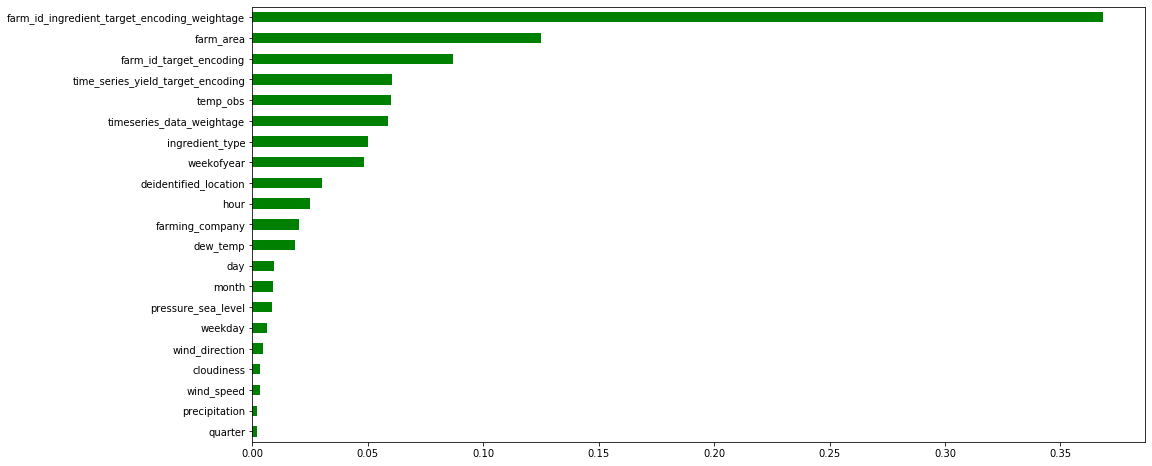

In [0]:
feat_importances = pd.Series(random_forest_tree_model.feature_importances_, index = X_train.columns)
%matplotlib inline
feat_importances.sort_values().plot(kind='barh',figsize=(16,8),color ='green')
plt.show()

In [0]:
random_forest_tree_model.predict(Test_data).shape

(20848800,)

In [0]:
random_forest_tree_model4178=pd.DataFrame(columns=['id','yield'])
random_forest_tree_model4178['id']=pd.read_csv('/content/drive/My Drive/Sudheer Projects/phd/test_data.csv')['id']
random_forest_tree_model4178['yield']=pd.Series(random_forest_tree_model.predict(Test_data))
random_forest_tree_model4178.to_csv('/content/drive/My Drive/Sudheer Projects/phd/random_forest_tree_model4178.csv',index=False)

In [0]:
#Test_data=load('/content/drive/My Drive/Sudheer Projects/phd/Model_building_dataSets/Test_data_final_without_id.pickle')
params={'max_depth': 5, 'min_samples_leaf': 100, 'min_samples_split': 4}
regressor = DecisionTreeRegressor(**params)
decision_tree_model=regressor.fit(x,y)
random_forest_tree_model4178=pd.DataFrame(columns=['id','yield'])
random_forest_tree_model4178['id']=pd.read_csv('/content/drive/My Drive/Sudheer Projects/phd/test_data.csv')['id']
random_forest_tree_model4178['yield']=pd.Series(decision_tree_model.predict(Test_data.drop(['quarter','cloudiness','precipitation','wind_speed'],axis=1)))
random_forest_tree_model4178.to_csv('/content/drive/My Drive/Sudheer Projects/phd/desicion_tree_best.csv',index=False)


In [0]:
random_forest_tree_model4178.tail()

,id,yield
20848795,41696845,74.785875
20848796,41696846,74.785875
20848797,41696847,376.262773
20848798,41696848,118.202512
20848799,41696849,154.225134


In [0]:
from keras.models import Sequential
from keras.layers import Dense,Input
neural_network = Sequential()

neural_network.add(Dense(32, input_dim=22, activation = 'sigmoid',
                         kernel_initializer = 'RandomUniform', bias_initializer = 'zeros'))

neural_network.add(Dense(10, activation = 'sigmoid', kernel_initializer = 'zeros',
                         bias_initializer = 'RandomUniform'))


neural_network.add(Dense(1, activation = 'softmax', kernel_initializer = 'zeros',
                         bias_initializer = 'RandomUniform'))
neural_network.summary()

from keras.optimizers import Adam

customized_optimizer = Adam(lr = 0.0001)

neural_network.compile(optimizer=customized_optimizer,
              loss='mean_squared_error',
              metrics=['mae'])




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 25,461
Trainable params: 25,461
Non-trainable params: 0
_________________________________________________________________



In [0]:
import time
start = time.time()

from joblib import  dump, load
Training_data=load('/content/drive/My Drive/Sudheer Projects/phd/Pure_code/train_data_model_building.joblib')


from keras.models import Sequential
from keras.layers import Dense,Input
neural_network = Sequential()

neural_network.add(Dense(32, input_dim=21, activation = 'relu',
                         kernel_initializer = 'RandomUniform', bias_initializer = 'zeros'))

neural_network.add(Dense(10, activation = 'relu', kernel_initializer = 'zeros',
                         bias_initializer = 'RandomUniform'))


neural_network.add(Dense(4, activation = 'relu', kernel_initializer = 'zeros',
                         bias_initializer = 'RandomUniform'))

neural_network.add(Dense(1, activation = 'linear', kernel_initializer = 'zeros',
                         bias_initializer = 'RandomUniform'))
neural_network.summary()

from keras.optimizers import Adam

customized_optimizer = Adam(lr = 0.0001)

neural_network.compile(optimizer=customized_optimizer,
              loss='mean_squared_error',
              metrics=['mae'])

training_history = neural_network.fit(Training_data.copy().drop(['yield'],axis=1), Training_data['yield'], epochs=25, batch_size=30000, validation_split=0.2)

done = time.time()
elapsed = done - start
print(elapsed)




Using TensorFlow backend.





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                704       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 44        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 1,083
Trainable params: 1,083
Non-trainable params: 0
_________________________________________________________________



In [0]:
test_data_id=load('/content/drive/My Drive/Sudheer Projects/phd/Model_building_dataSets/Test_data_final_with_id.pickle')

In [0]:
sample_submision=pd.read_csv('/content/drive/My Drive/Sudheer Projects/phd/sample_submission1-1578562773139.csv')

In [0]:
test_data_id.columns

Index(['ingredient_type', 'id', 'timeseries_data_weightage',
       'farm_id_target_encoding',
       'farm_id_ingredient_target_encoding_weightage', 'farm_area',
       'farming_company', 'deidentified_location', 'temp_obs', 'cloudiness',
       'wind_direction', 'dew_temp', 'pressure_sea_level', 'precipitation',
       'wind_speed', 'time_series_yield_target_encoding', 'month', 'day',
       'hour', 'weekday', 'quarter', 'weekofyear'],
      dtype='object')

In [0]:
Test_data=pd.merge(sample_submision,test_data_id,on=['id'],how='left')

In [0]:
Test_data=Test_data.reindex(['ingredient_type', 'farm_area', 'farming_company',
       'deidentified_location', 'temp_obs', 'cloudiness', 'wind_direction',
       'dew_temp', 'pressure_sea_level', 'precipitation', 'wind_speed',
       'month', 'day', 'hour', 'weekday', 'quarter', 'weekofyear',
       'time_series_yield_target_encoding', 'timeseries_data_weightage',
       'farm_id_target_encoding',
       'farm_id_ingredient_target_encoding_weightage','id','yield'],axis=1)

In [0]:
Test_data.drop(['id','yield'],inplace=True,axis=1)

In [0]:
from joblib import dump,load
dump(Test_data,'/content/drive/My Drive/Sudheer Projects/phd/new_test_data_fully_model_ready.joblib')

['/content/drive/My Drive/Sudheer Projects/phd/new_test_data_fully_model_ready.joblib']

In [0]:
import pandas as pd
import numpy as np
import time
from joblib import load,dump
Training_data=load('/content/drive/My Drive/Sudheer Projects/phd/Pure_code/train_data_model_building.joblib')
start = time.time()


from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor

X_train,X_test,Y_train,Y_test=model_selection.train_test_split(Training_data.copy().drop(['yield'],axis=1),Training_data['yield'],test_size=0.3,random_state=20)
print("Train validation split successful")
#params={'n_estimators': 8, 'min_samples_split': 2 , 'n_jobs' : -1 ,'min_samples_leaf': 1}
#regressor = RandomForestRegressor(**params)
regressor = RandomForestRegressor(n_jobs=-1)
random_forest_tree_model=regressor.fit(X_train, Y_train)

print("Model fit complete")

Y_pred_train = random_forest_tree_model.predict(X_train)
Y_pred_test=random_forest_tree_model.predict(X_test)

from sklearn.metrics import mean_squared_error
mse_train=mean_squared_error(Y_train,Y_pred_train)
mse_test=mean_squared_error(Y_test,Y_pred_test)

import numpy as np 
rmse_test=np.sqrt(mse_test)
rmse_train=np.sqrt(mse_train)
print("Train RMSE")
print(np.sqrt(mse_train))
print("Validation RMSE")
print(np.sqrt(mse_test))

done = time.time()
elapsed = done - start
print(elapsed)



Train validation split successful


In [6]:
import time
start = time.time()
from joblib import dump,load
Training_data=load('/content/drive/My Drive/Sudheer Projects/phd/Pure_code/train_data_model_building.joblib')

from sklearn import model_selection

X_train,X_test,Y_train,Y_test=model_selection.train_test_split(Training_data.copy().drop('yield',axis=1),Training_data['yield'],test_size=0.3,random_state=4)


from sklearn.tree import DecisionTreeRegressor
params={'max_depth': 5, 'min_samples_leaf': 100, 'min_samples_split': 4}
regressor = DecisionTreeRegressor(**params)
#regressor = DecisionTreeRegressor()
decision_tree_model=regressor.fit(X_train, Y_train)

Y_pred_train = decision_tree_model.predict(X_train)
Y_pred_test=decision_tree_model.predict(X_test)
from sklearn.metrics import mean_squared_error
mse_train=mean_squared_error(Y_train,Y_pred_train)
mse_test=mean_squared_error(Y_test,Y_pred_test)

import numpy as np 
rmse_test=np.sqrt(mse_test)
rmse_train=np.sqrt(mse_train)
print("Train RMSE")
print(np.sqrt(mse_train))
print("Test RMSE")
print(np.sqrt(mse_test))

done = time.time()
elapsed = done - start
print(elapsed)




Train RMSE
290.42195016077704
Test RMSE
291.085644130517
156.54785084724426


In [7]:
regressor

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=100, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [0]:
decision_tree_model=regressor.fit(Training_data.copy().drop('yield',axis=1), Training_data['yield'])
neural_net_model=pd.DataFrame(columns=['id','yield'])
neural_net_model['id']=pd.read_csv('/content/drive/My Drive/Sudheer Projects/phd/sample_submission1-1578562773139.csv')['id']
neural_net_model['yield']=pd.Series(regressor.predict(load('/content/drive/My Drive/Sudheer Projects/phd/new_test_data_fully_model_ready.joblib')))
neural_net_model.to_csv('/content/drive/My Drive/decision_tree_submission.csv',index=False)

In [3]:
pd.read_csv('/content/drive/My Drive/Sudheer Projects/phd/test_data.csv')

,date,farm_id,ingredient_type,id
0,2017-01-01 00:00:00,fid_110884,ing_w,0
1,2017-01-01 00:00:00,fid_90053,ing_w,1
2,2017-01-01 00:00:00,fid_17537,ing_w,2
3,2017-01-01 00:00:00,fid_110392,ing_w,3
4,2017-01-01 00:00:00,fid_62402,ing_w,4
...,...,...,...,...
20848795,2017-12-25 07:00:00,fid_58769,ing_x,41696845
20848796,2017-12-25 07:00:00,fid_58769,ing_z,41696846
20848797,2017-12-25 07:00:00,fid_117010,ing_w,41696847
20848798,2017-12-25 07:00:00,fid_117010,ing_x,41696848


In [4]:
pd.read_csv('/content/drive/My Drive/Sudheer Projects/phd/sample_submission1-1578562773139.csv')

,id,yield
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
999994,999995,0
999995,999996,0
999996,999997,0
999997,999998,0


In [0]:
new_test=pd.merge(pd.read_csv('/content/drive/My Drive/Sudheer Projects/phd/sample_submission1-1578562773139.csv'),pd.read_csv('/content/drive/My Drive/Sudheer Projects/phd/test_data.csv'),on=['id'],how='left')

In [0]:
new_test.drop('yield',axis=1,inplace=True)

In [8]:
dump(new_test,'/content/drive/My Drive/Sudheer Projects/phd/new_test_data.joblib')

['/content/drive/My Drive/Sudheer Projects/phd/new_test_data.joblib']